In [1]:
import numpy as np
import random as rd
import math

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

In [2]:
num_agents = 10
seed = 42

T = 250
mu = 0.1

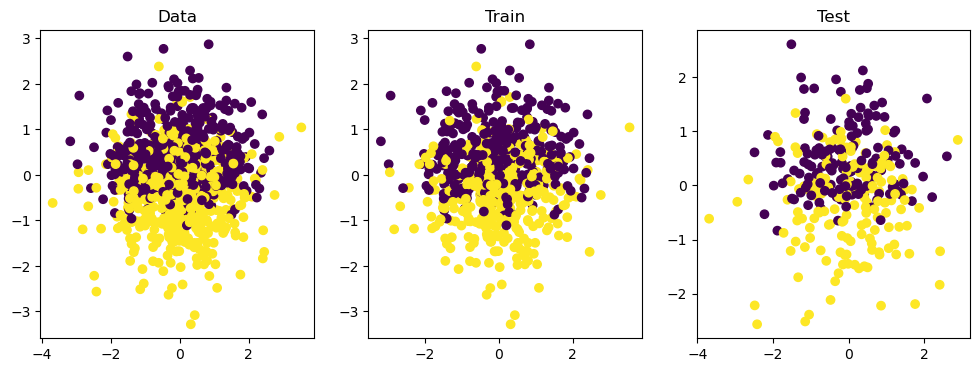

In [3]:
X, Y = make_classification(n_samples=1000, n_classes=2, random_state=seed)
#X, Y = make_moons(n_samples=1000, noise=0.3, random_state=seed)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.3)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

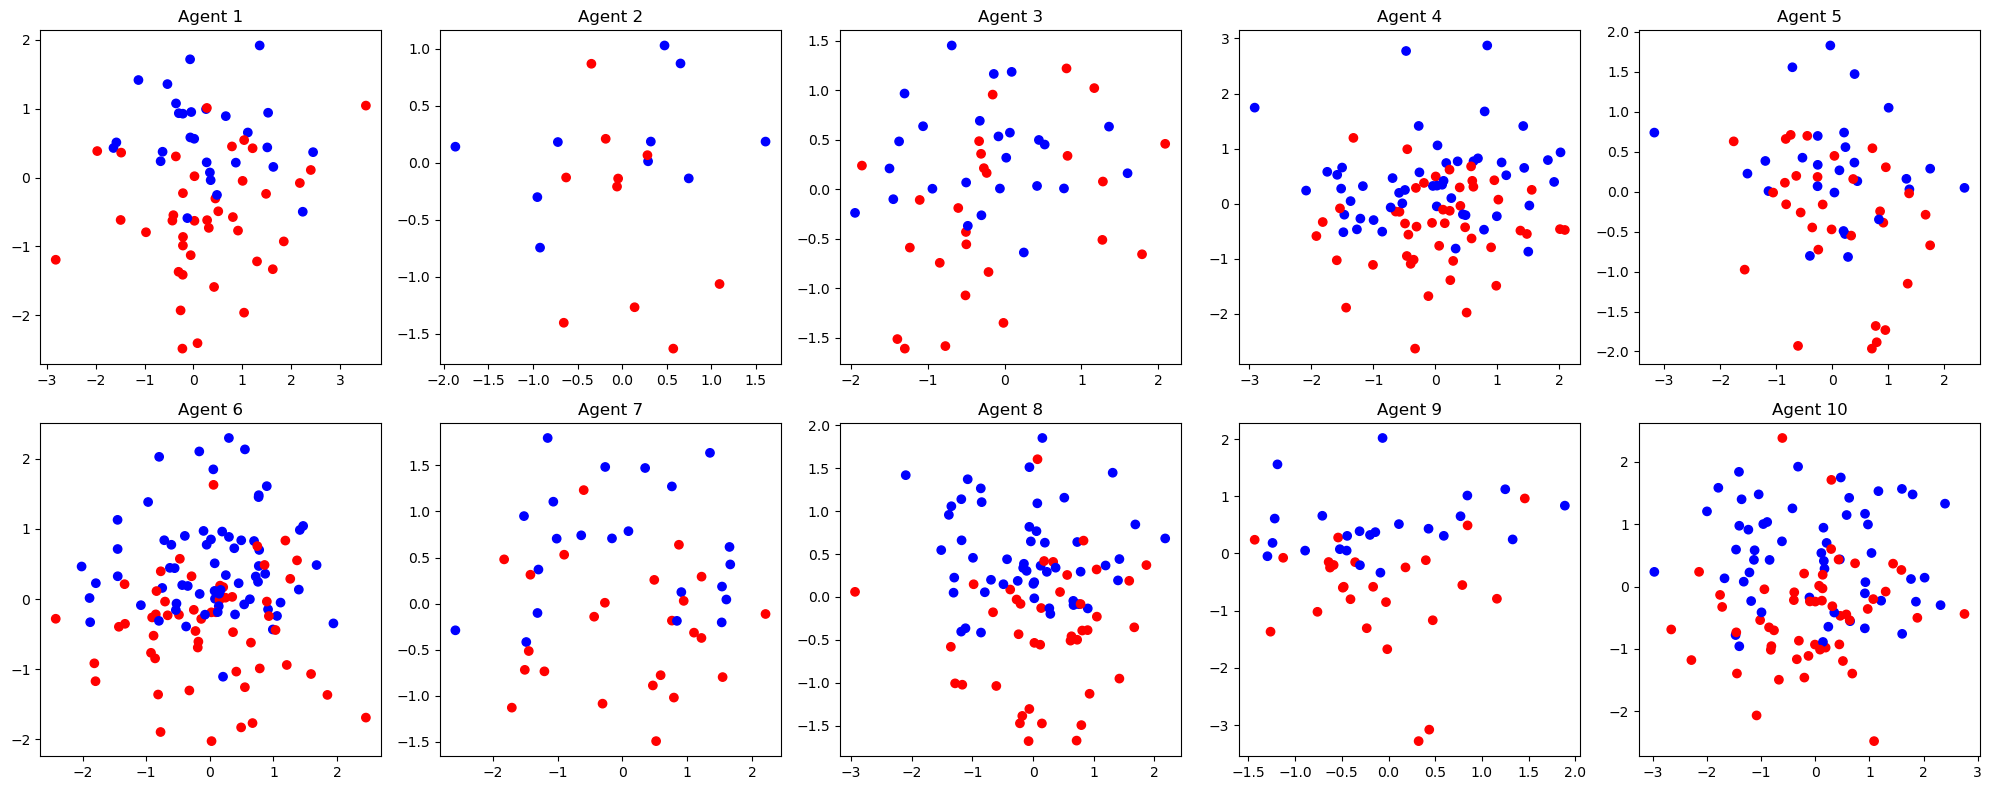

In [4]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, num_subsets=num_agents, random_state=seed)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train, num_subsets=num_agents)


fig, axes = plt.subplots(nrows=2, ncols=int(num_agents/2), figsize=(20, 8))

for i in range(num_agents):
    row = i // (num_agents // 2)
    col = i % (num_agents // 2)
    colors = ['blue' if y== 0 else 'red' for y in Y_agent[i]]
    axes[row, col].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [5]:
X_agent_augmented = []
for i in range(num_agents):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4, X_agent[i]**5], axis=1))

X_agent_augmented = X_agent

In [6]:
X_test_augmented = X_test #np.concatenate([X_test, X_test**2, X_test**3, X_test**4, X_test**5], axis=1)
X_train_augmented = X_train #np.concatenate([X_train, X_train**2, X_train**3, X_train**4, X_train**5], axis=1)

In [7]:
G = np.zeros((num_agents, num_agents))
for i in range(num_agents):
    for j in range(num_agents):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(num_agents)
c = np.zeros(num_agents)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(num_agents):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize

print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 120
Min: 20
Mean: 70.0
G: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
D: [1. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
c: [0.55833333 0.16666667 0.41666667 0.79166667 0.48333333 1.
 0.38333333 0.75833333 0.4        0.875     ]


## Training

### Single Global Model

In [8]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

train_acc = np.zeros((T))
test_acc = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)

    train_acc[i] = lr.accuracy(thetas_mono, X_train_augmented, Y_train)
    test_acc[i] = lr.accuracy(thetas_mono, X_test_augmented, Y_test)

    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

Iteration 0 : Train: 1.2573 | Test: 1.1812
Iteration 25 : Train: 0.3877 | Test: 0.4396
Iteration 50 : Train: 0.3285 | Test: 0.3967
Iteration 75 : Train: 0.3155 | Test: 0.3876
Iteration 100 : Train: 0.3114 | Test: 0.3848
Iteration 125 : Train: 0.3097 | Test: 0.3838
Iteration 150 : Train: 0.3090 | Test: 0.3835
Iteration 175 : Train: 0.3087 | Test: 0.3834
Iteration 200 : Train: 0.3086 | Test: 0.3835
Iteration 225 : Train: 0.3085 | Test: 0.3836


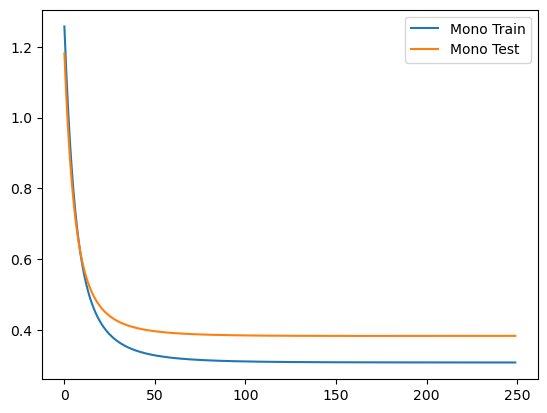

In [9]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

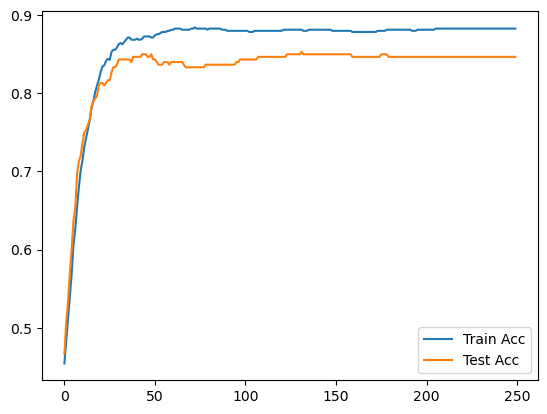

In [10]:
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.legend()
plt.show()

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [11]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))
costs_train_alone = np.zeros(T)
costs_test_alone = np.zeros(T)
acc_train_agents_alone = np.zeros((T, num_agents))
acc_test_agents_alone = np.zeros((T, num_agents))

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)

            acc_train_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_test_augmented, Y_test)

    costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.0429 , 0.9919) | (15.7740 , 14.7144)
 25 : (0.3216 , 0.5243) | (11.6729 , 11.3487)
 50 : (0.2488 , 0.4906) | (14.0658 , 13.8115)
 75 : (0.2221 , 0.4897) | (17.2529 , 17.0227)
100 : (0.2070 , 0.4970) | (20.7539 , 20.5369)
125 : (0.1967 , 0.5074) | (24.4126 , 24.2045)
150 : (0.1889 , 0.5191) | (28.1598 , 27.9584)
175 : (0.1827 , 0.5313) | (31.9574 , 31.7614)
200 : (0.1776 , 0.5434) | (35.7810 , 35.5895)
225 : (0.1733 , 0.5555) | (39.6134 , 39.4258)


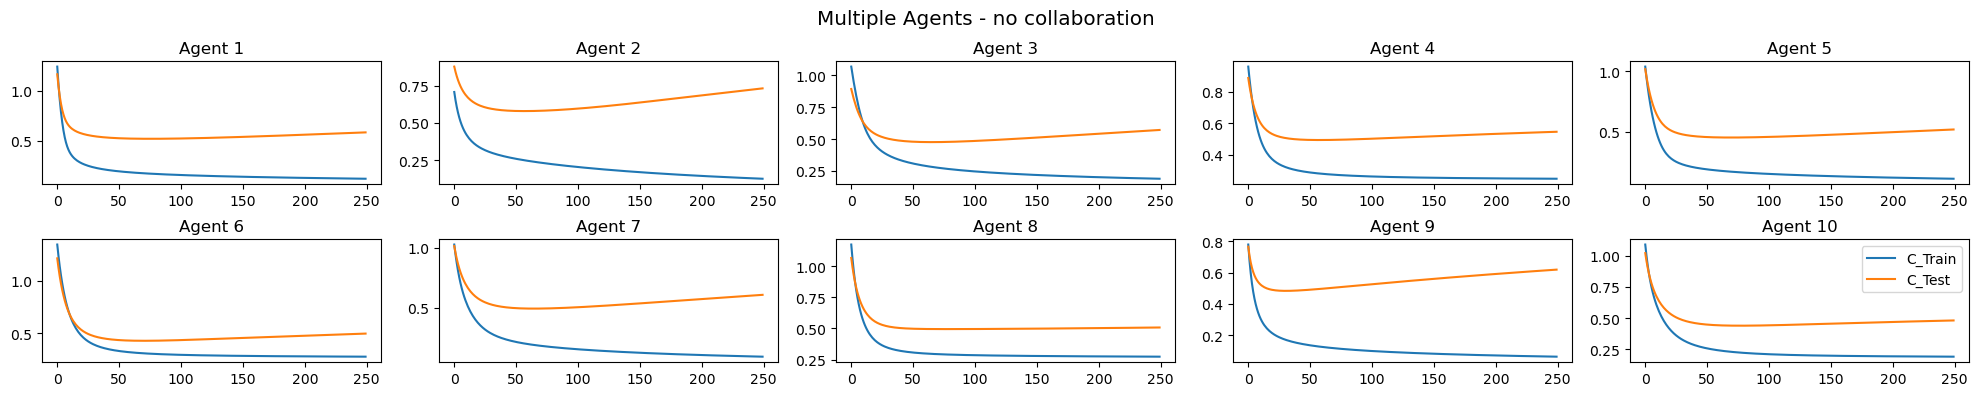

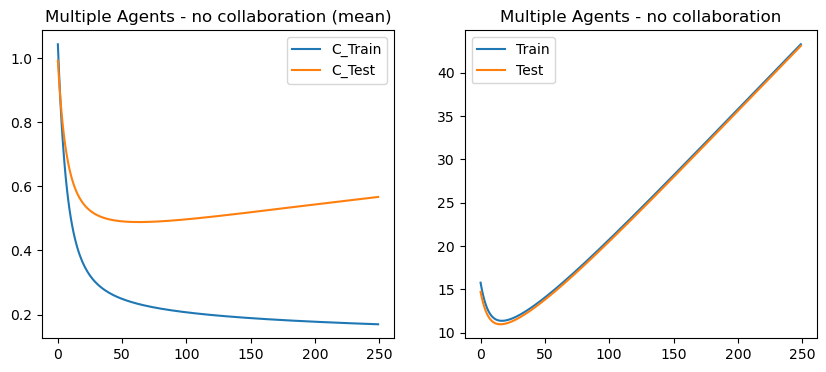

In [12]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, costs_train_alone, costs_test_alone, "Multiple Agents - no collaboration")

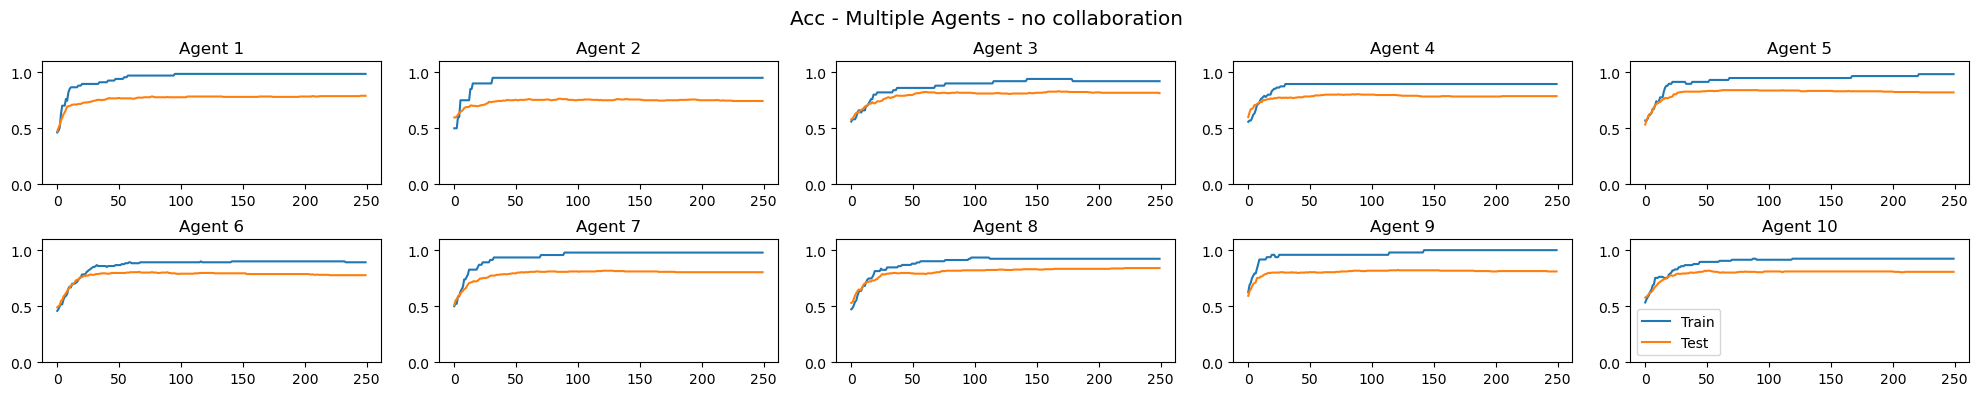

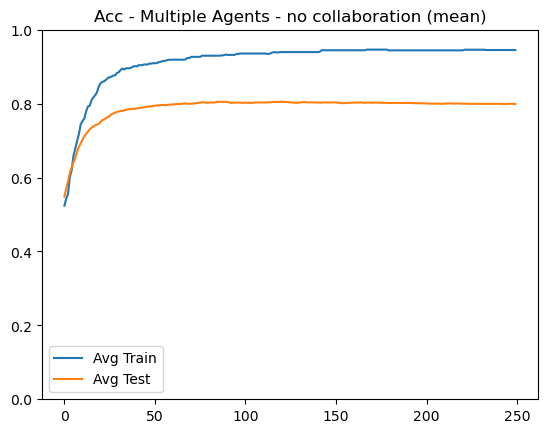

In [13]:
util.plot_accuracy(num_agents, acc_train_agents_alone, acc_test_agents_alone, "Acc - Multiple Agents - no collaboration")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [14]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))
costs_train = np.zeros(T)
costs_test = np.zeros(T)
acc_train_agents = np.zeros((T, num_agents))
acc_test_agents = np.zeros((T, num_agents))

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)

            acc_train_agents[i,j] = lr.accuracy(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents[i,j] = lr.accuracy(thetas_agents[j], X_test_augmented, Y_test)
    costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.0417 , 0.9820) | (12.1818 , 11.1269)
 25 : (0.3503 , 0.4735) | (1.9146 , 1.5751)
 50 : (0.2882 , 0.4274) | (1.5609 , 1.2800)
 75 : (0.2715 , 0.4155) | (1.5137 , 1.2479)
100 : (0.2649 , 0.4113) | (1.5199 , 1.2600)
125 : (0.2618 , 0.4097) | (1.5365 , 1.2794)
150 : (0.2601 , 0.4092) | (1.5540 , 1.2984)
175 : (0.2591 , 0.4092) | (1.5697 , 1.3150)
200 : (0.2585 , 0.4094) | (1.5831 , 1.3290)
225 : (0.2581 , 0.4097) | (1.5943 , 1.3406)


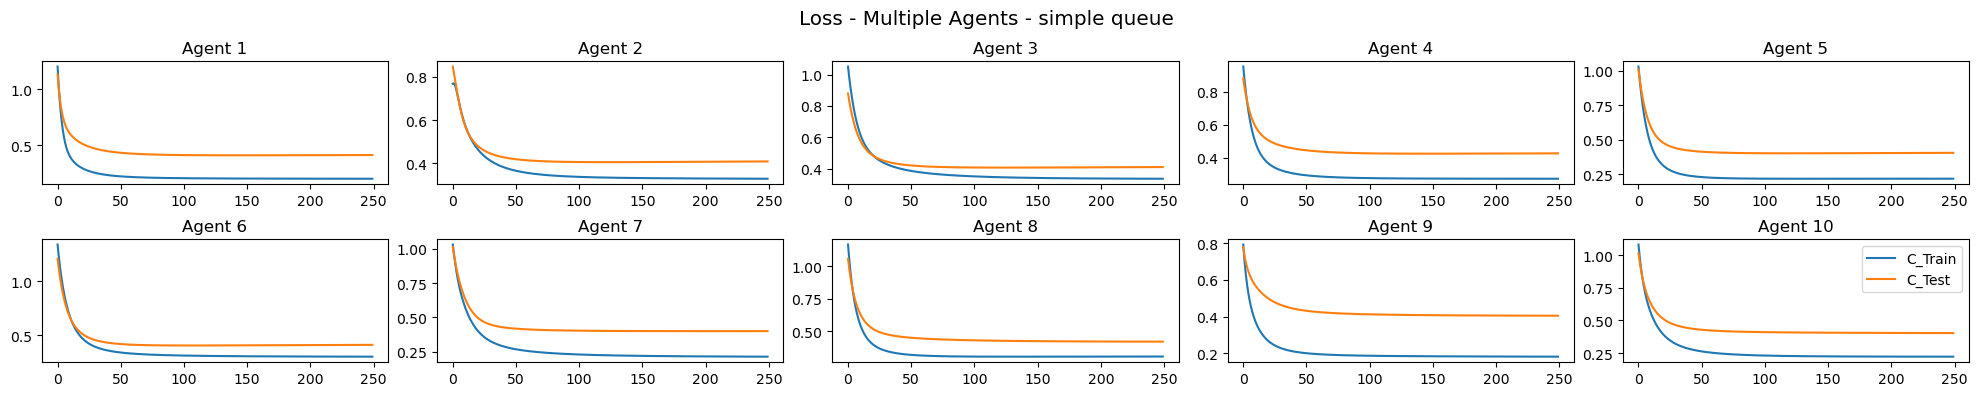

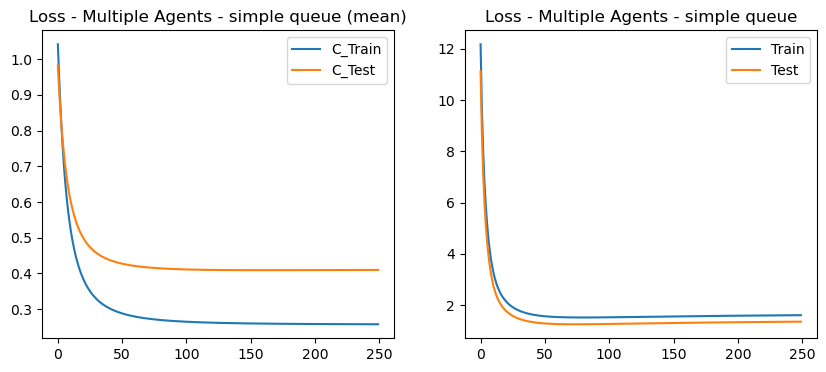

In [15]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, costs_train, costs_test, "Loss - Multiple Agents - simple queue")

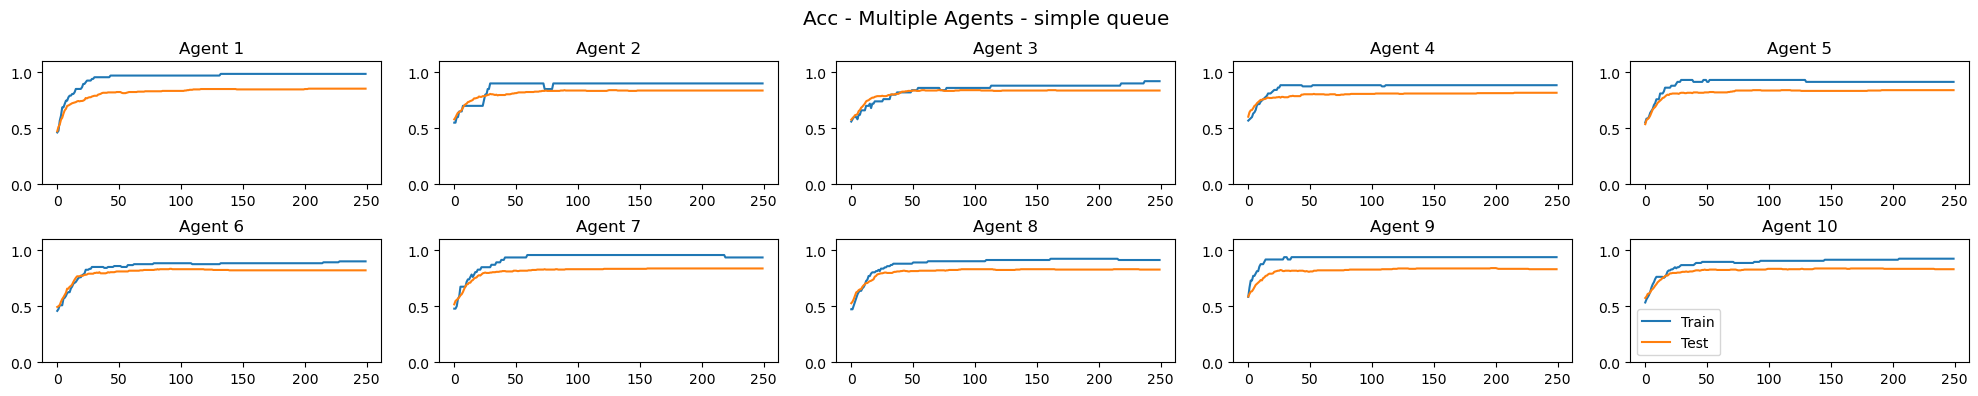

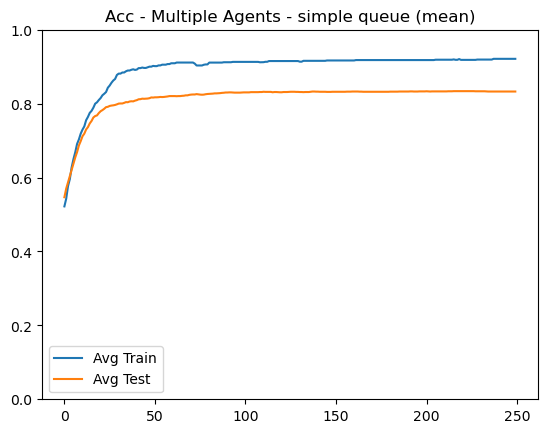

In [16]:
util.plot_accuracy(num_agents, acc_train_agents, acc_test_agents, "Acc - Multiple Agents - simple queue")

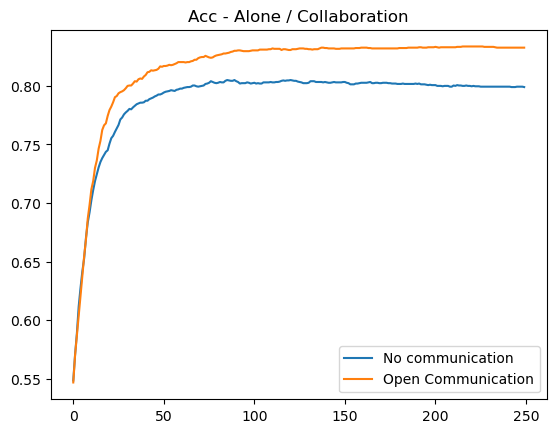

In [17]:
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No communication")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Communication")
plt.legend()
plt.title("Acc - Alone / Collaboration")
plt.show()

### Random drawing of Agents

randint with global quota

In [18]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))
costs_test_rand = np.zeros(total_T)
costs_train_rand = np.zeros(total_T)

acc_test_agents_rand = np.zeros((total_T, num_agents))               
acc_train_agents_rand = np.zeros((total_T, num_agents))


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)

    acc_train_agents_rand[i, j] = lr.accuracy(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_rand[i, j] = lr.accuracy(thetas_agents_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_rand[i]):.4f} , {np.mean(costs_test_agents_rand[i]):.4f}) | ({costs_train_rand[int(i/10)]:.4f} , {costs_test_rand[int(i/10)]:.4f})')

costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)
costs_train_rand = costs_train_rand[:T]
costs_test_rand = costs_test_rand[:T]

acc_train_agents_rand = util.reduce_cost_matrix(acc_train_agents_rand)
acc_test_agents_rand = util.reduce_cost_matrix(acc_test_agents_rand)


Iter: Agents_Mean       | Total 
  0 : (0.0797 , 0.0781) | (16.3727 , 15.2097)
 25 : (0.0403 , 0.0461) | (2.1692 , 1.8189)
 50 : (0.0258 , 0.0426) | (1.6351 , 1.3518)
 75 : (0.0242 , 0.0407) | (1.5278 , 1.2605)
100 : (0.0304 , 0.0428) | (1.5191 , 1.2582)
125 : (0.0306 , 0.0403) | (1.5318 , 1.2742)
150 : (0.0303 , 0.0404) | (1.5446 , 1.2889)
175 : (0.0218 , 0.0403) | (1.5636 , 1.3088)
200 : (0.0219 , 0.0404) | (1.5734 , 1.3193)
225 : (0.0304 , 0.0419) | (1.5879 , 1.3342)


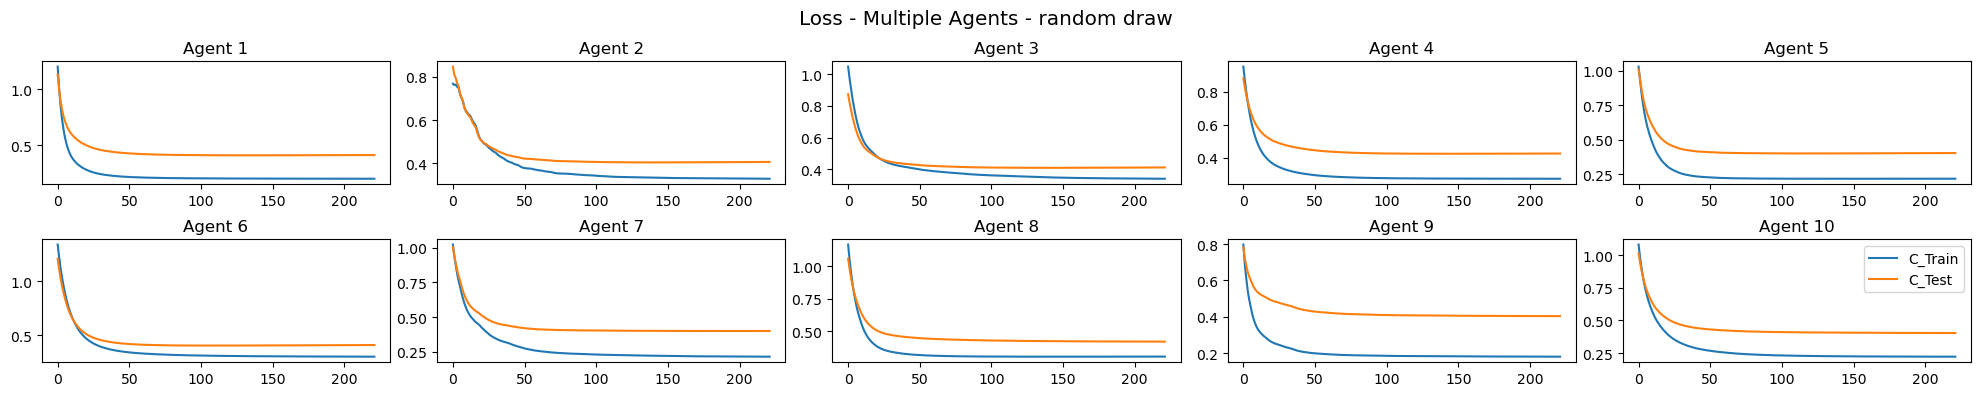

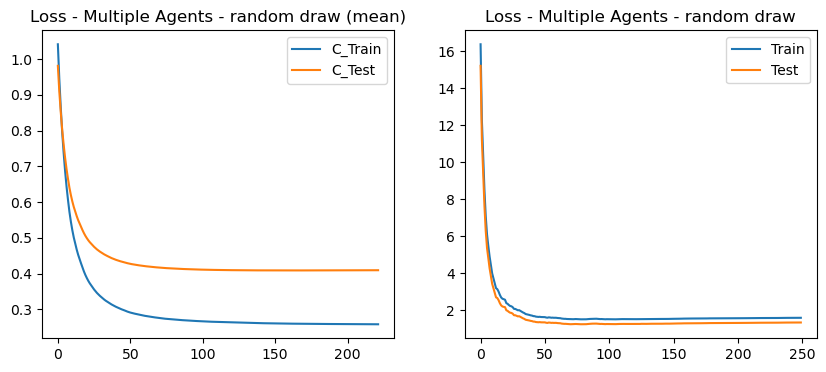

In [19]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, costs_train_rand, costs_test_rand, "Loss - Multiple Agents - random draw")

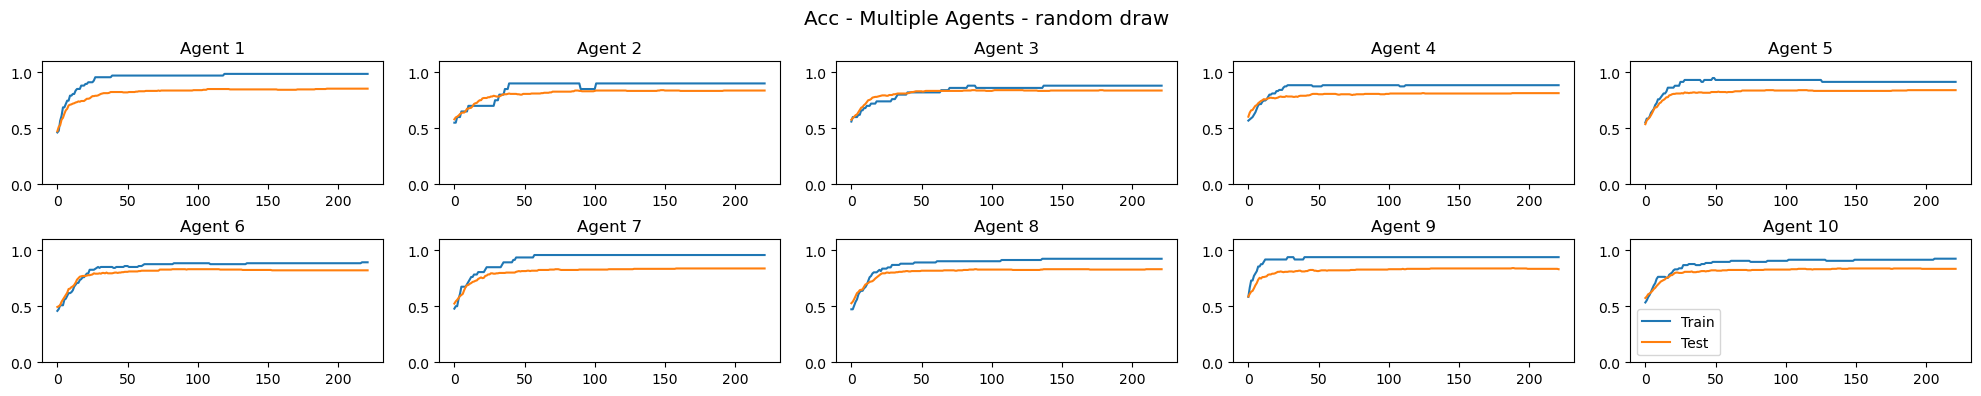

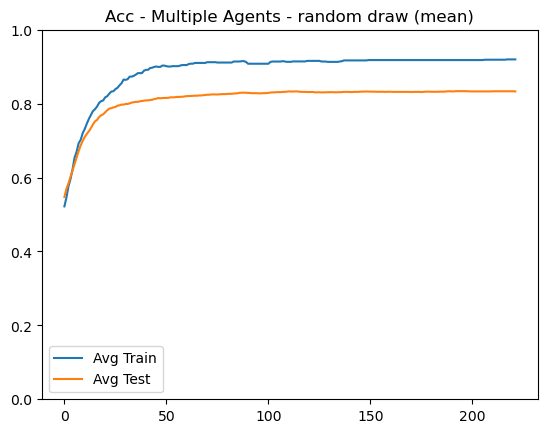

In [20]:
util.plot_accuracy(num_agents, acc_train_agents_rand, acc_test_agents_rand, "Acc - Multiple Agents - random draw")

### Weighting of Agents

In [21]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))
costs_test_weigh = np.zeros(total_T)
costs_train_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(num_agents, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_weigh[i]):.4f} , {np.mean(costs_test_agents_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_weigh = costs_train_weigh[:max_non_zero]
costs_test_weigh = costs_test_weigh[:max_non_zero]


[0.09571429 0.02857143 0.07142857 0.13571429 0.08285714 0.17142857
 0.06571429 0.13       0.06857143 0.15      ]
Iter: Agents_Mean       | Total 
  0 : (0.1035 , 0.1016) | (16.4447 , 15.2783)
 25 : (0.0343 , 0.0472) | (1.9831 , 1.6474)
 50 : (0.0318 , 0.0404) | (1.6832 , 1.4051)
 75 : (0.0237 , 0.0403) | (1.5993 , 1.3349)
100 : (0.0304 , 0.0425) | (1.5641 , 1.3047)
125 : (0.0302 , 0.0405) | (1.5775 , 1.3207)
150 : (0.0223 , 0.0405) | (1.5831 , 1.3278)
175 : (0.0204 , 0.0411) | (1.5928 , 1.3384)
200 : (0.0222 , 0.0403) | (1.6016 , 1.3478)
225 : (0.0272 , 0.0426) | (1.6085 , 1.3550)


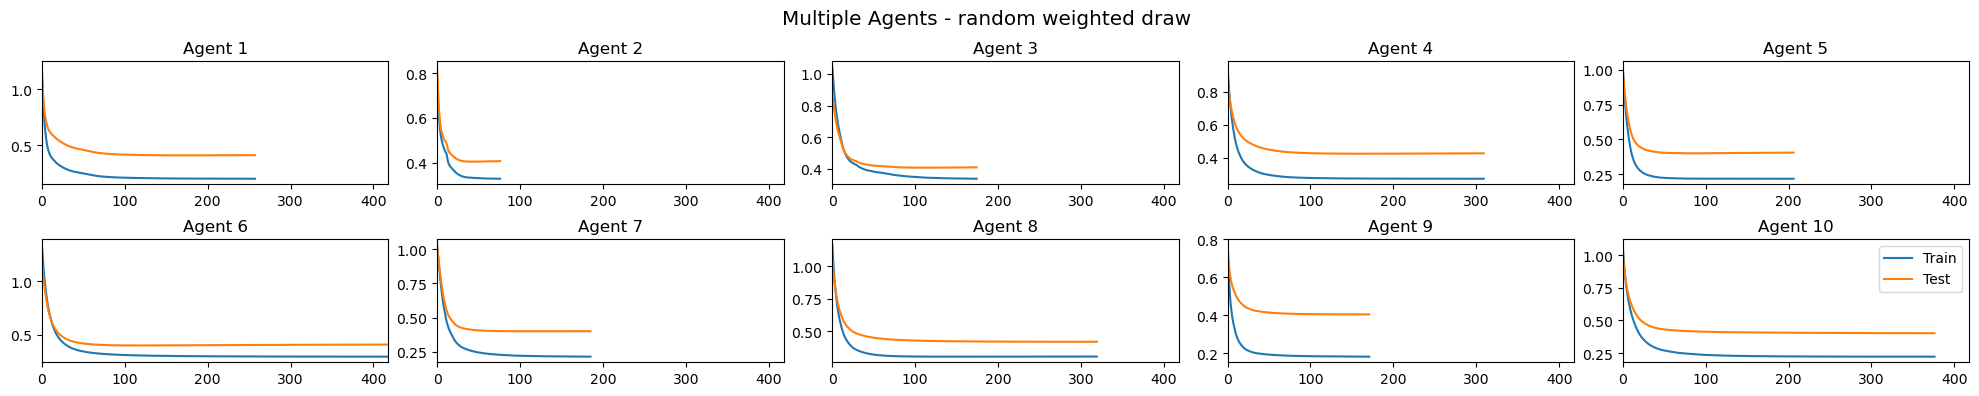

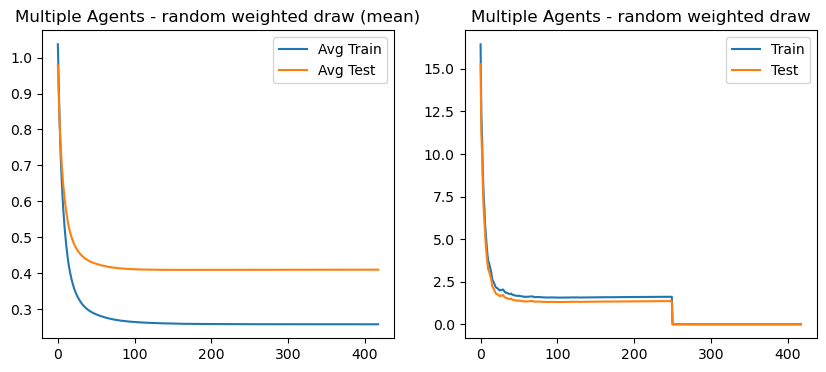

In [22]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, costs_train_weigh, costs_test_weigh, "Multiple Agents - random weighted draw")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.

Ici on peut avoir des $\bar{\epsilon}$ très élevés


In [23]:
epsilon = 0.5 # -> ici on a donc epsilon_barre = epsilon * T = 500
L_0 = 0.25

In [24]:
np.random.seed(seed)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

acc_train_private = np.zeros(T)
acc_test_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    acc_train_private[i] = lr.accuracyAll(num_agents, thetas_private, X_agent_augmented, Y_agent)
    acc_test_private[i] = lr.accuracyAll(num_agents, thetas_private, [X_test_augmented for i in range(num_agents)], [Y_test for i in range(num_agents)])
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

Iteration 0 : Train: 12.2113 | Test: 11.1565
Iteration 25 : Train: 1.9214 | Test: 1.5822
Iteration 50 : Train: 1.6050 | Test: 1.3243
Iteration 75 : Train: 1.5228 | Test: 1.2562
Iteration 100 : Train: 1.5509 | Test: 1.2907
Iteration 125 : Train: 1.5472 | Test: 1.2900
Iteration 150 : Train: 1.5738 | Test: 1.3179
Iteration 175 : Train: 1.6025 | Test: 1.3479
Iteration 200 : Train: 1.6303 | Test: 1.3766
Iteration 225 : Train: 1.6344 | Test: 1.3811


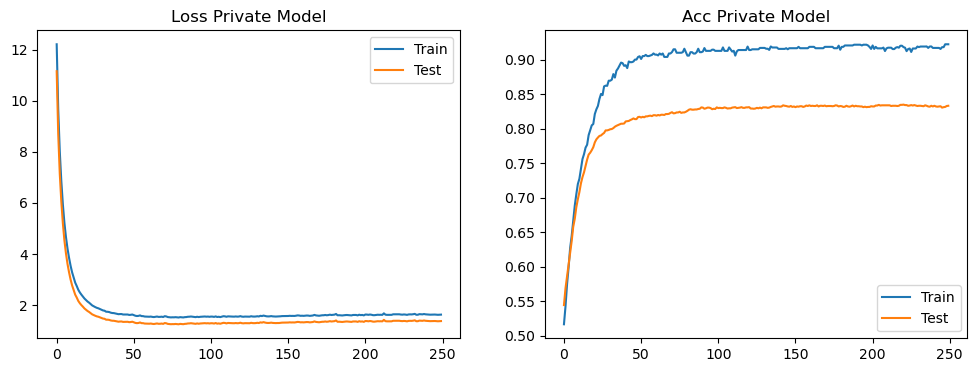

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.legend()
plt.title("Loss Private Model")

plt.subplot(1, 2, 2)
plt.plot(acc_train_private, label="Train")
plt.plot(acc_test_private, label="Test")
plt.title("Acc Private Model")
plt.legend()
plt.show()

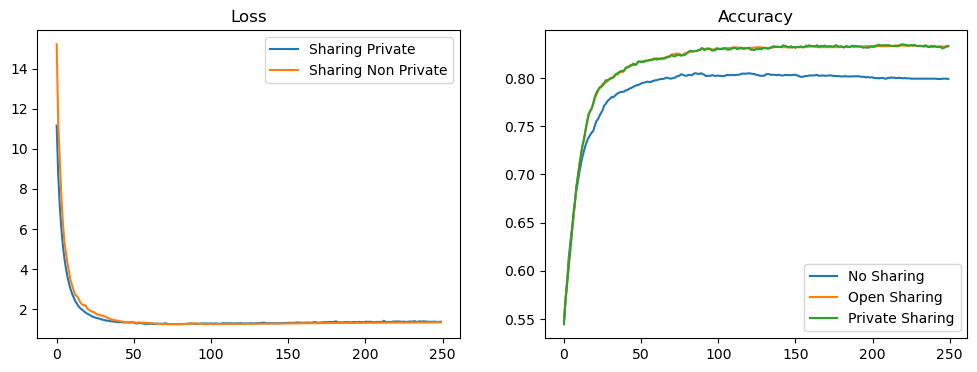

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(costs_test_private, label="Sharing Private")
#plt.plot(costs_test_alone, label="No Sharing")
plt.plot(costs_test_rand, label="Sharing Non Private")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No Sharing")
#plt.plot(np.mean(acc_test_agents_rand, axis=1), label="Open Sharing (rand)")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Sharing")
plt.plot(acc_test_private, label="Private Sharing")
# plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.show()

### Random drawing using constant epsilon

In [27]:

# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

#epsilon_barre = 500

epsilon = 0.5
L_0 = 0.25

print(type(epsilon))

np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_private_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_rand = np.zeros((total_T, num_agents))

costs_test_private_rand = np.zeros(total_T)
costs_train_private_rand = np.zeros(total_T)

acc_test_agents_private_rand = np.zeros((total_T, num_agents))               
acc_train_agents_private_rand = np.zeros((total_T, num_agents))


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_private_rand = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon) 

    costs_train_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_test_augmented, Y_test)

    acc_train_agents_private_rand[i, j] = lr.accuracy(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_private_rand[i, j] = lr.accuracy(thetas_agents_private_rand[j], X_test_augmented, Y_test)
    
    if i % 10 == 0:
        costs_train_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_rand[i]):.4f} , {np.mean(costs_test_agents_private_rand[i]):.4f}) | ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f})')

costs_train_agents_private_rand = util.reduce_cost_matrix(costs_train_agents_private_rand)
costs_test_agents_private_rand = util.reduce_cost_matrix(costs_test_agents_private_rand)
costs_train_private_rand = costs_train_private_rand[:T]
costs_test_private_rand = costs_test_private_rand[:T]

acc_train_agents_private_rand = util.reduce_cost_matrix(acc_train_agents_private_rand)
acc_test_agents_private_rand = util.reduce_cost_matrix(acc_test_agents_private_rand)

<class 'float'>
Iter: Agents_Mean       | Total 
  0 : (0.1339 , 0.1208) | (16.4228 , 15.2753)
 25 : (0.0342 , 0.0486) | (2.0435 , 1.6985)
 50 : (0.0289 , 0.0439) | (1.6011 , 1.3181)
 75 : (0.0212 , 0.0420) | (1.5304 , 1.2641)
100 : (0.0308 , 0.0403) | (1.5563 , 1.2963)
125 : (0.0218 , 0.0402) | (1.5523 , 1.2944)
150 : (0.0204 , 0.0411) | (1.5578 , 1.3013)
175 : (0.0272 , 0.0424) | (1.5888 , 1.3337)
200 : (0.0181 , 0.0405) | (1.6015 , 1.3470)
225 : (0.0218 , 0.0405) | (1.6218 , 1.3680)


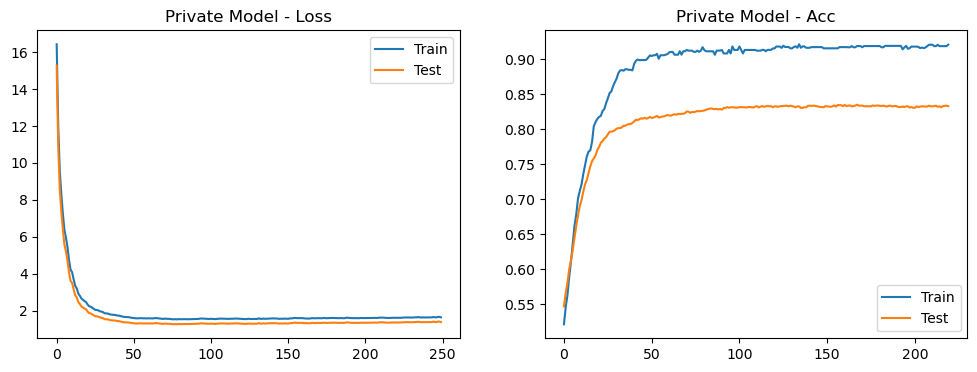

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(costs_train_private_rand, label="Train")
plt.plot(costs_test_private_rand, label="Test")
plt.title("Private Model - Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.mean(acc_train_agents_private_rand, axis=1), label="Train")
plt.plot(np.mean(acc_test_agents_private_rand, axis=1), label="Test")
plt.title("Private Model - Acc")
plt.legend()
plt.show()

### Weighted drawing with constant epsilons

In [29]:

# DEFINING EPSILON_BAR
epsilon_barre = 500
L_0 = 0.25

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh = np.zeros((total_T, num_agents))

costs_test_private_weigh = np.zeros(total_T)
costs_train_private_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# des probabilités, on déduit l'espérance du nombre d'itérations pour chaque agent
nb_iterations = np.zeros(num_agents)
for i in range (num_agents):
    nb_iterations = coeffs_pond * total_T


# puis les epsilon correspondants pour chaque agent
epsilon = np.zeros(num_agents)
for i in range(num_agents): 
    epsilon[i] = epsilon_barre / nb_iterations[i]
"""
print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')
"""
print()

print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(num_agents, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_private_weigh = ml.stepForwardPrivate_2(thetas_agents_private_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon[j])

    costs_train_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh[i]):.4f} , {np.mean(costs_test_agents_private_weigh[i]):.4f}) | ({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh)
costs_test_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh = costs_train_private_weigh[:T]
costs_test_private_weigh = costs_test_private_weigh[:T]



Iter: Agents_Mean       | Total 
  0 : (0.1035 , 0.1016) | (16.4441 , 15.2776)
 25 : (0.0324 , 0.0479) | (2.0546 , 1.7230)
 50 : (0.0399 , 0.0429) | (1.6425 , 1.3656)
 75 : (0.0234 , 0.0413) | (1.5862 , 1.3223)
100 : (0.0209 , 0.0416) | (1.5745 , 1.3155)
125 : (0.0302 , 0.0405) | (1.5776 , 1.3209)
150 : (0.0344 , 0.0408) | (1.5853 , 1.3301)
175 : (0.0304 , 0.0420) | (1.5955 , 1.3412)
200 : (0.0222 , 0.0403) | (1.5982 , 1.3443)
225 : (0.0338 , 0.0410) | (1.6097 , 1.3564)


In [30]:
print("Iter: Total_Mean_rand   | Total_Mean_weigh")
for i in range (total_T):
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f}) | (({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')


Iter: Total_Mean_rand   | Total_Mean_weigh
  0 : (16.4228 , 15.2753) | ((16.4441 , 15.2776)
 25 : (2.0435 , 1.6985) | ((2.0546 , 1.7230)
 50 : (1.6011 , 1.3181) | ((1.6425 , 1.3656)
 75 : (1.5304 , 1.2641) | ((1.5862 , 1.3223)
100 : (1.5563 , 1.2963) | ((1.5745 , 1.3155)
125 : (1.5523 , 1.2944) | ((1.5776 , 1.3209)
150 : (1.5578 , 1.3013) | ((1.5853 , 1.3301)
175 : (1.5888 , 1.3337) | ((1.5955 , 1.3412)
200 : (1.6015 , 1.3470) | ((1.5982 , 1.3443)
225 : (1.6218 , 1.3680) | ((1.6097 , 1.3564)


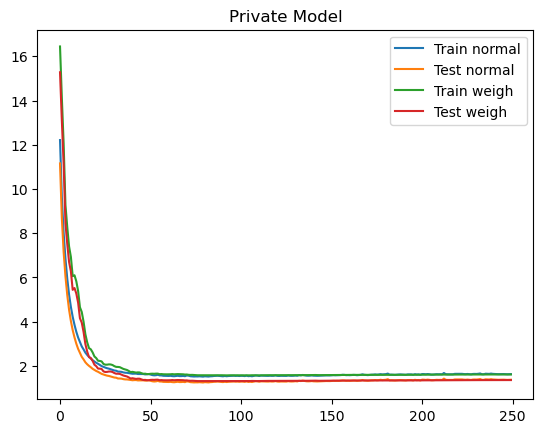

In [31]:
plt.plot(costs_train_private, label="Train normal")
plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.title("Private Model")
plt.legend()
plt.show()

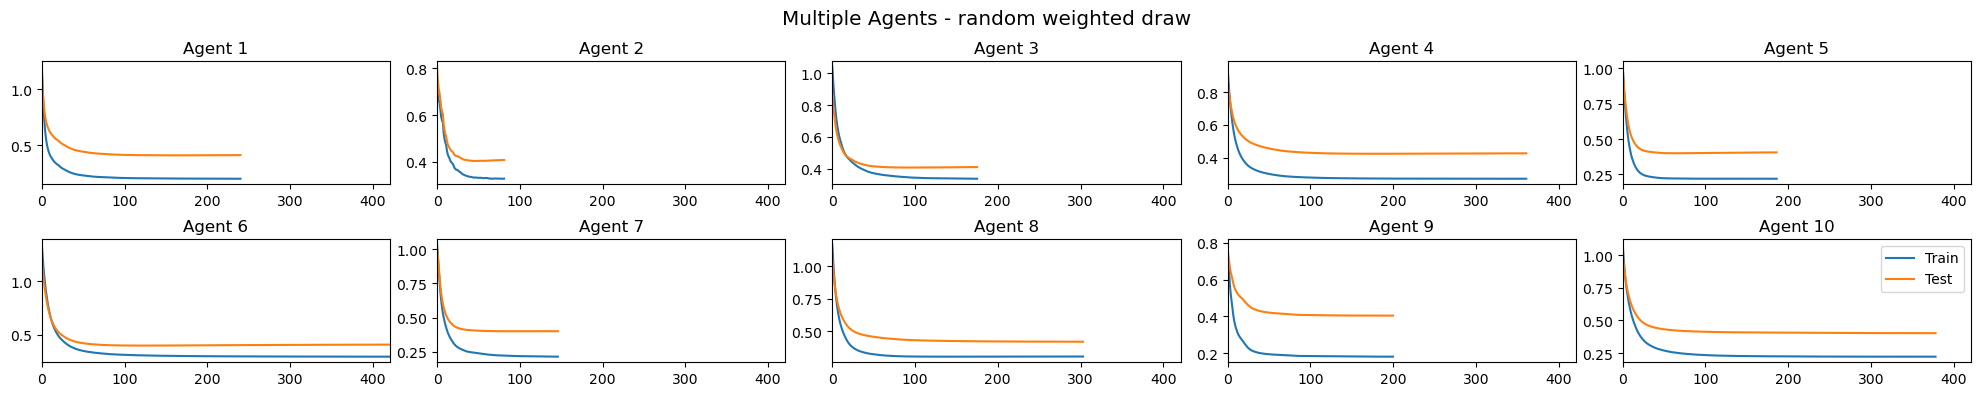

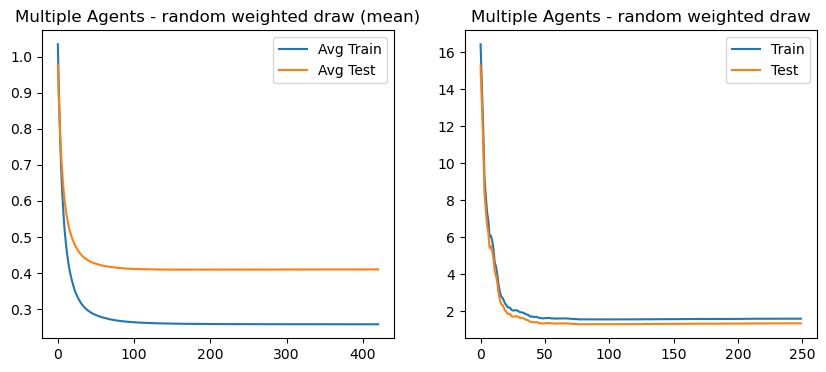

In [32]:
util.plot_curves_non_zero(num_agents, costs_train_agents_private_weigh_shifted, costs_test_agents_private_weigh_shifted, costs_train_private_weigh, costs_test_private_weigh, "Multiple Agents - random weighted draw")

### Weighted epsilons  implementing theorem 2 : optimal choice of epsilon

In [33]:

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh_2 = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))
costs_test_private_weigh_2 = np.zeros(total_T)
costs_train_private_weigh_2 = np.zeros(total_T)

acc_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
acc_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# on doit calculer grand C = 1 - sigma /(n*Lmax)
# sigma - strongly convex  : correspond à Ql
# Lmax : max Li, les Li sont les constantesblock lipschitz du gradient de Ql
sigma = 0.05                                                                                       # randomly chosen at the moment
Lmax = 20
epsilon_bar = 500
L_0 = 0.25

big_c = 1 - sigma/(num_agents*Lmax)
cube = big_c ** (1/3)
print(cube)
print()

lambdas = np.zeros(num_agents)
agent_choice = np.zeros(total_T)
agent_pre = np.zeros(total_T)
epsilons = np.zeros(total_T)

# we have to know in advance at which iterations each machine wakes up, and we compute our lambdas


for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    agent_choice[i] = j
    res = (cube-1) / ((cube ** total_T)-1) * (cube ** (i+1))
    agent_pre[i] = res
    lambdas[j] += res
    
for i in range(total_T) :
    epsilons[i] = agent_pre[i] * epsilon_bar / lambdas[int(agent_choice[i])]
    

count = 0
sum = 0
epsi_by_agent  = np.zeros(num_agents)
count_by_agent = np.zeros(num_agents)
first = np.zeros(num_agents)
last = np.zeros(num_agents)

for i in range(total_T):    
    if epsi_by_agent[int(agent_choice[i])] == 0:
        first[int(agent_choice[i])] = epsilons[i]
    last[int(agent_choice[i])] = epsilons[i]
    epsi_by_agent[int(agent_choice[i])] +=epsilons[i]
    count_by_agent[int(agent_choice[i])] += 1
    
for i in range(num_agents):
    epsi_by_agent[i] = epsi_by_agent[i] / count_by_agent[i]

rate_epsi = first - last


print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = int(agent_choice[i])
    epsi = epsilons[i]
    thetas_agents_private_weigh_2 = ml.stepForwardPrivate_2(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsi)

    costs_train_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test))

    acc_train_agents_private_weigh_2[i, j] = lr.accuracy(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_private_weigh_2[i, j] = lr.accuracy(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh_2[i]):.4f} , {np.mean(costs_test_agents_private_weigh_2[i]):.4f}) | ({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')

# costs_train_agents_weigh_2 = util.reduce_cost_matrix(costs_train_agents_weigh_2)
# costs_test_agents_weigh_2 = util.reduce_cost_matrix(costs_test_agents_weigh_2)

costs_train_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh_2)
costs_test_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh_2)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted_2, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh_2 = costs_train_private_weigh_2[:T]
costs_test_private_weigh_2 = costs_test_private_weigh_2[:T]

acc_train_agents_private_weigh_2 = util.reduce_cost_matrix(acc_train_agents_private_weigh_2)
acc_test_agents_private_weigh_2 = util.reduce_cost_matrix(acc_test_agents_private_weigh_2)

0.9999166597212575

[0.09571429 0.02857143 0.07142857 0.13571429 0.08285714 0.17142857
 0.06571429 0.13       0.06857143 0.15      ]
Iter: Agents_Mean       | Total 
  0 : (0.1035 , 0.1016) | (16.4456 , 15.2792)
 25 : (0.0343 , 0.0472) | (1.9823 , 1.6467)
 50 : (0.0318 , 0.0404) | (1.6833 , 1.4052)
 75 : (0.0237 , 0.0403) | (1.5997 , 1.3353)
100 : (0.0304 , 0.0425) | (1.5633 , 1.3038)
125 : (0.0302 , 0.0405) | (1.5781 , 1.3213)
150 : (0.0223 , 0.0405) | (1.5830 , 1.3277)
175 : (0.0204 , 0.0411) | (1.5937 , 1.3393)
200 : (0.0222 , 0.0403) | (1.6026 , 1.3488)
225 : (0.0272 , 0.0426) | (1.6100 , 1.3565)


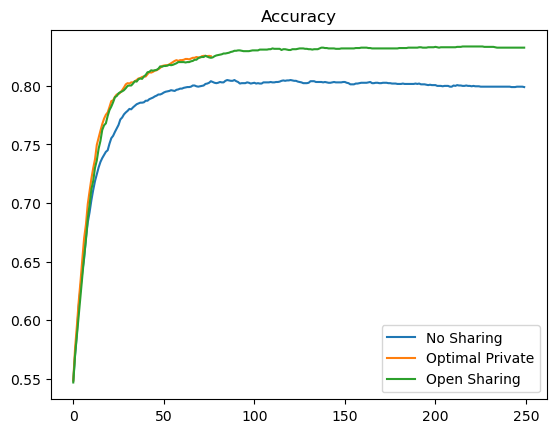

In [34]:
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No Sharing")
plt.plot(np.mean(acc_test_agents_private_weigh_2, axis=1), label="Optimal Private")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Sharing")
#plt.plot(acc_test_private, label="Private Sharing")
# plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.show()

In [35]:
print("Iter: Total_Mean_rand   | Total_Mean_weigh")
for i in range (total_T):
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f}) | (({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')


Iter: Total_Mean_rand   | Total_Mean_weigh
  0 : (16.4441 , 15.2776) | ((16.4456 , 15.2792)
 25 : (2.0546 , 1.7230) | ((1.9823 , 1.6467)
 50 : (1.6425 , 1.3656) | ((1.6833 , 1.4052)
 75 : (1.5862 , 1.3223) | ((1.5997 , 1.3353)
100 : (1.5745 , 1.3155) | ((1.5633 , 1.3038)
125 : (1.5776 , 1.3209) | ((1.5781 , 1.3213)
150 : (1.5853 , 1.3301) | ((1.5830 , 1.3277)
175 : (1.5955 , 1.3412) | ((1.5937 , 1.3393)
200 : (1.5982 , 1.3443) | ((1.6026 , 1.3488)
225 : (1.6097 , 1.3564) | ((1.6100 , 1.3565)


In [36]:


print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')

print()
print("Agent : Iterations  | epsilon | epsilon_barre | delta_epsilon ")
for i in range(num_agents):
    print(f'{int(i):3} : ({count_by_agent[i]:.4f}) | ({epsi_by_agent[i]:.4f}) | ({epsi_by_agent[i]*count_by_agent[i]}) | ({rate_epsi[i]:.4f}))')

Agent : Iterations  | epsilon | epsilon_barre
  0 : (239.2857) | (2.0896) | (500.00000000000006)
  1 : (71.4286) | (7.0000) | (500.0)
  2 : (178.5714) | (2.8000) | (500.0)
  3 : (339.2857) | (1.4737) | (500.00000000000006)
  4 : (207.1429) | (2.4138) | (500.0)
  5 : (428.5714) | (1.1667) | (500.00000000000006)
  6 : (164.2857) | (3.0435) | (500.0)
  7 : (325.0000) | (1.5385) | (500.0)
  8 : (171.4286) | (2.9167) | (500.0)
  9 : (375.0000) | (1.3333) | (500.0)

Agent : Iterations  | epsilon | epsilon_barre | delta_epsilon 
  0 : (258.0000) | (1.9380) | (499.9999999999998) | (0.4021))
  1 : (77.0000) | (6.4935) | (500.0000000000002) | (1.3388))
  2 : (175.0000) | (2.8571) | (500.0000000000001) | (0.5868))
  3 : (310.0000) | (1.6129) | (500.00000000000034) | (0.3354))
  4 : (207.0000) | (2.4155) | (500.0000000000004) | (0.4968))
  5 : (418.0000) | (1.1962) | (500.0000000000001) | (0.2478))
  6 : (186.0000) | (2.6882) | (499.99999999999966) | (0.5576))
  7 : (320.0000) | (1.5625) | (499.99

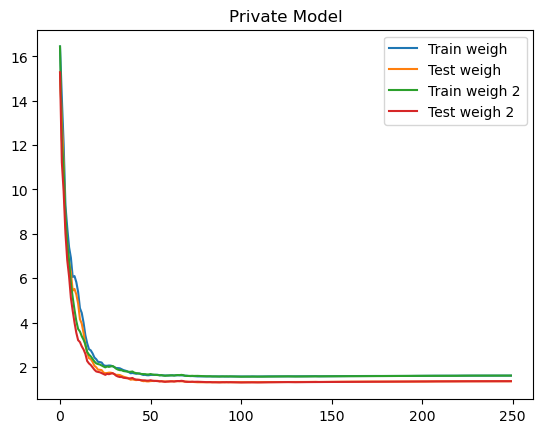

In [37]:
#plt.plot(costs_train_private, label="Train normal")
#plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.plot(costs_train_private_weigh_2, label="Train weigh 2")
plt.plot(costs_test_private_weigh_2, label="Test weigh 2")
plt.title("Private Model")
plt.legend()
plt.show()

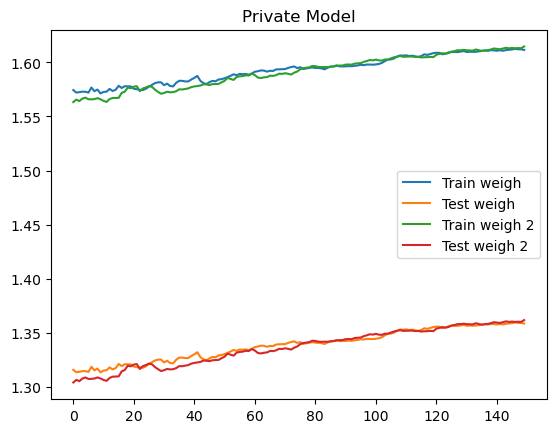

In [38]:
costs_train_private_weigh = costs_train_private_weigh[100:]
costs_test_private_weigh = costs_test_private_weigh[100:]
costs_train_private_weigh_2 = costs_train_private_weigh_2[100:]
costs_test_private_weigh_2 = costs_test_private_weigh_2[100:]

plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.plot(costs_train_private_weigh_2, label="Train weigh 2")
plt.plot(costs_test_private_weigh_2, label="Test weigh 2")
plt.title("Private Model")
plt.legend()
plt.show()

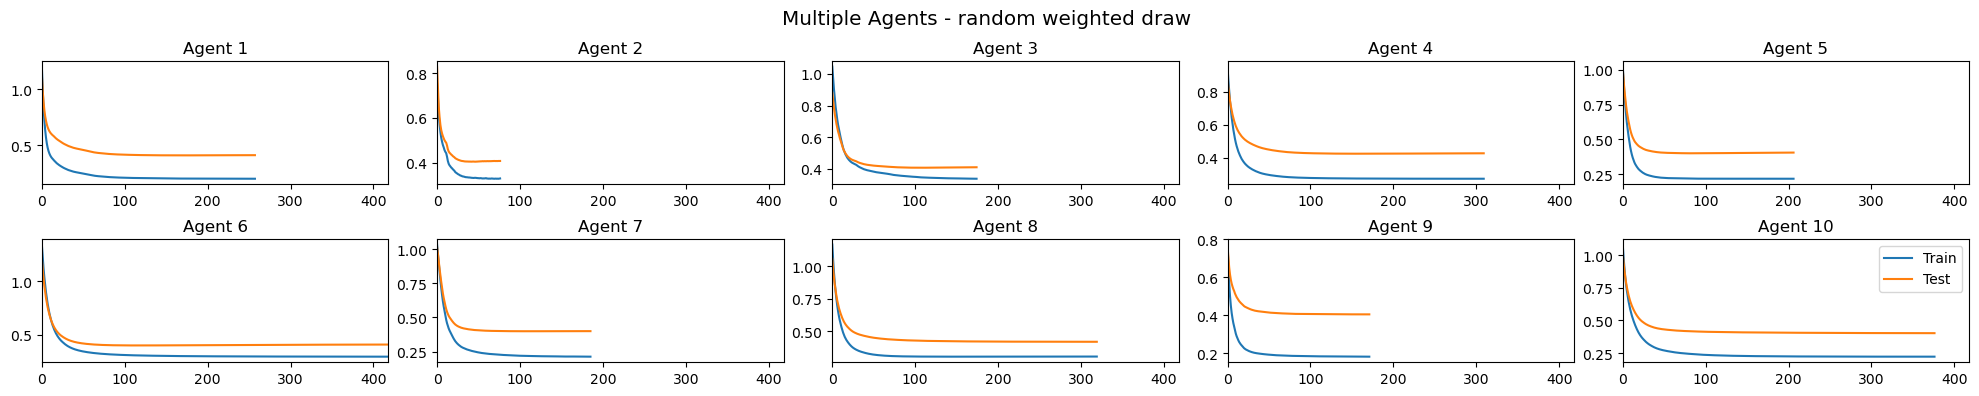

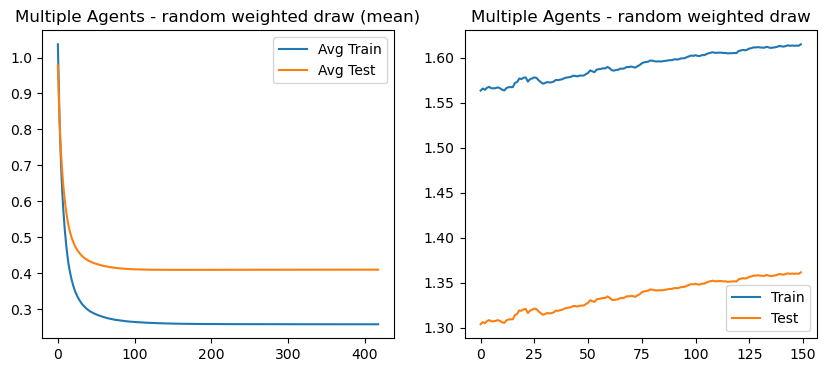

In [39]:
util.plot_curves_non_zero(num_agents, costs_train_agents_private_weigh_shifted_2, costs_test_agents_private_weigh_shifted_2, costs_train_private_weigh_2, costs_test_private_weigh_2, "Multiple Agents - random weighted draw")